## PROGRAMMA PER STIMARE ENERGIA DALL'ETF

In [1]:
import os
import glob
import uproot
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from matplotlib.colors import LinearSegmentedColormap

### Lettura dei dati

In [2]:
#leggere dati da file in ciclo e salvarli in array

path = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data"

if not path.endswith(os.sep):
    path += os.sep

file_names = ["0V.txt"] + [f"{v}V.txt" for v in range(95, 106)]

bias_all = []  # lista con I(Bias)
tes_all  = []  # lista con I(TES)
voltages = []  # lista con la tensione corrispondente

for fname in file_names:
    full_path = os.path.join(path, fname)
    try:
        # carica due colonne di numeri dal file e separa le colonne
        data = np.loadtxt(full_path)
        I_bias = data[:, 0]
        I_tes  = data[:, 1]
        
        bias_all.append(I_bias)
        tes_all.append(I_tes)

        # estrai la tensione dal nome del file (es. "95V.txt" → 95)
        voltage = float(fname.replace("V.txt", ""))
        voltages.append(voltage)
        
    except Exception as e:
        print(f"Errore leggendo {fname}: {e}")

### Grafico ites-ibias generale

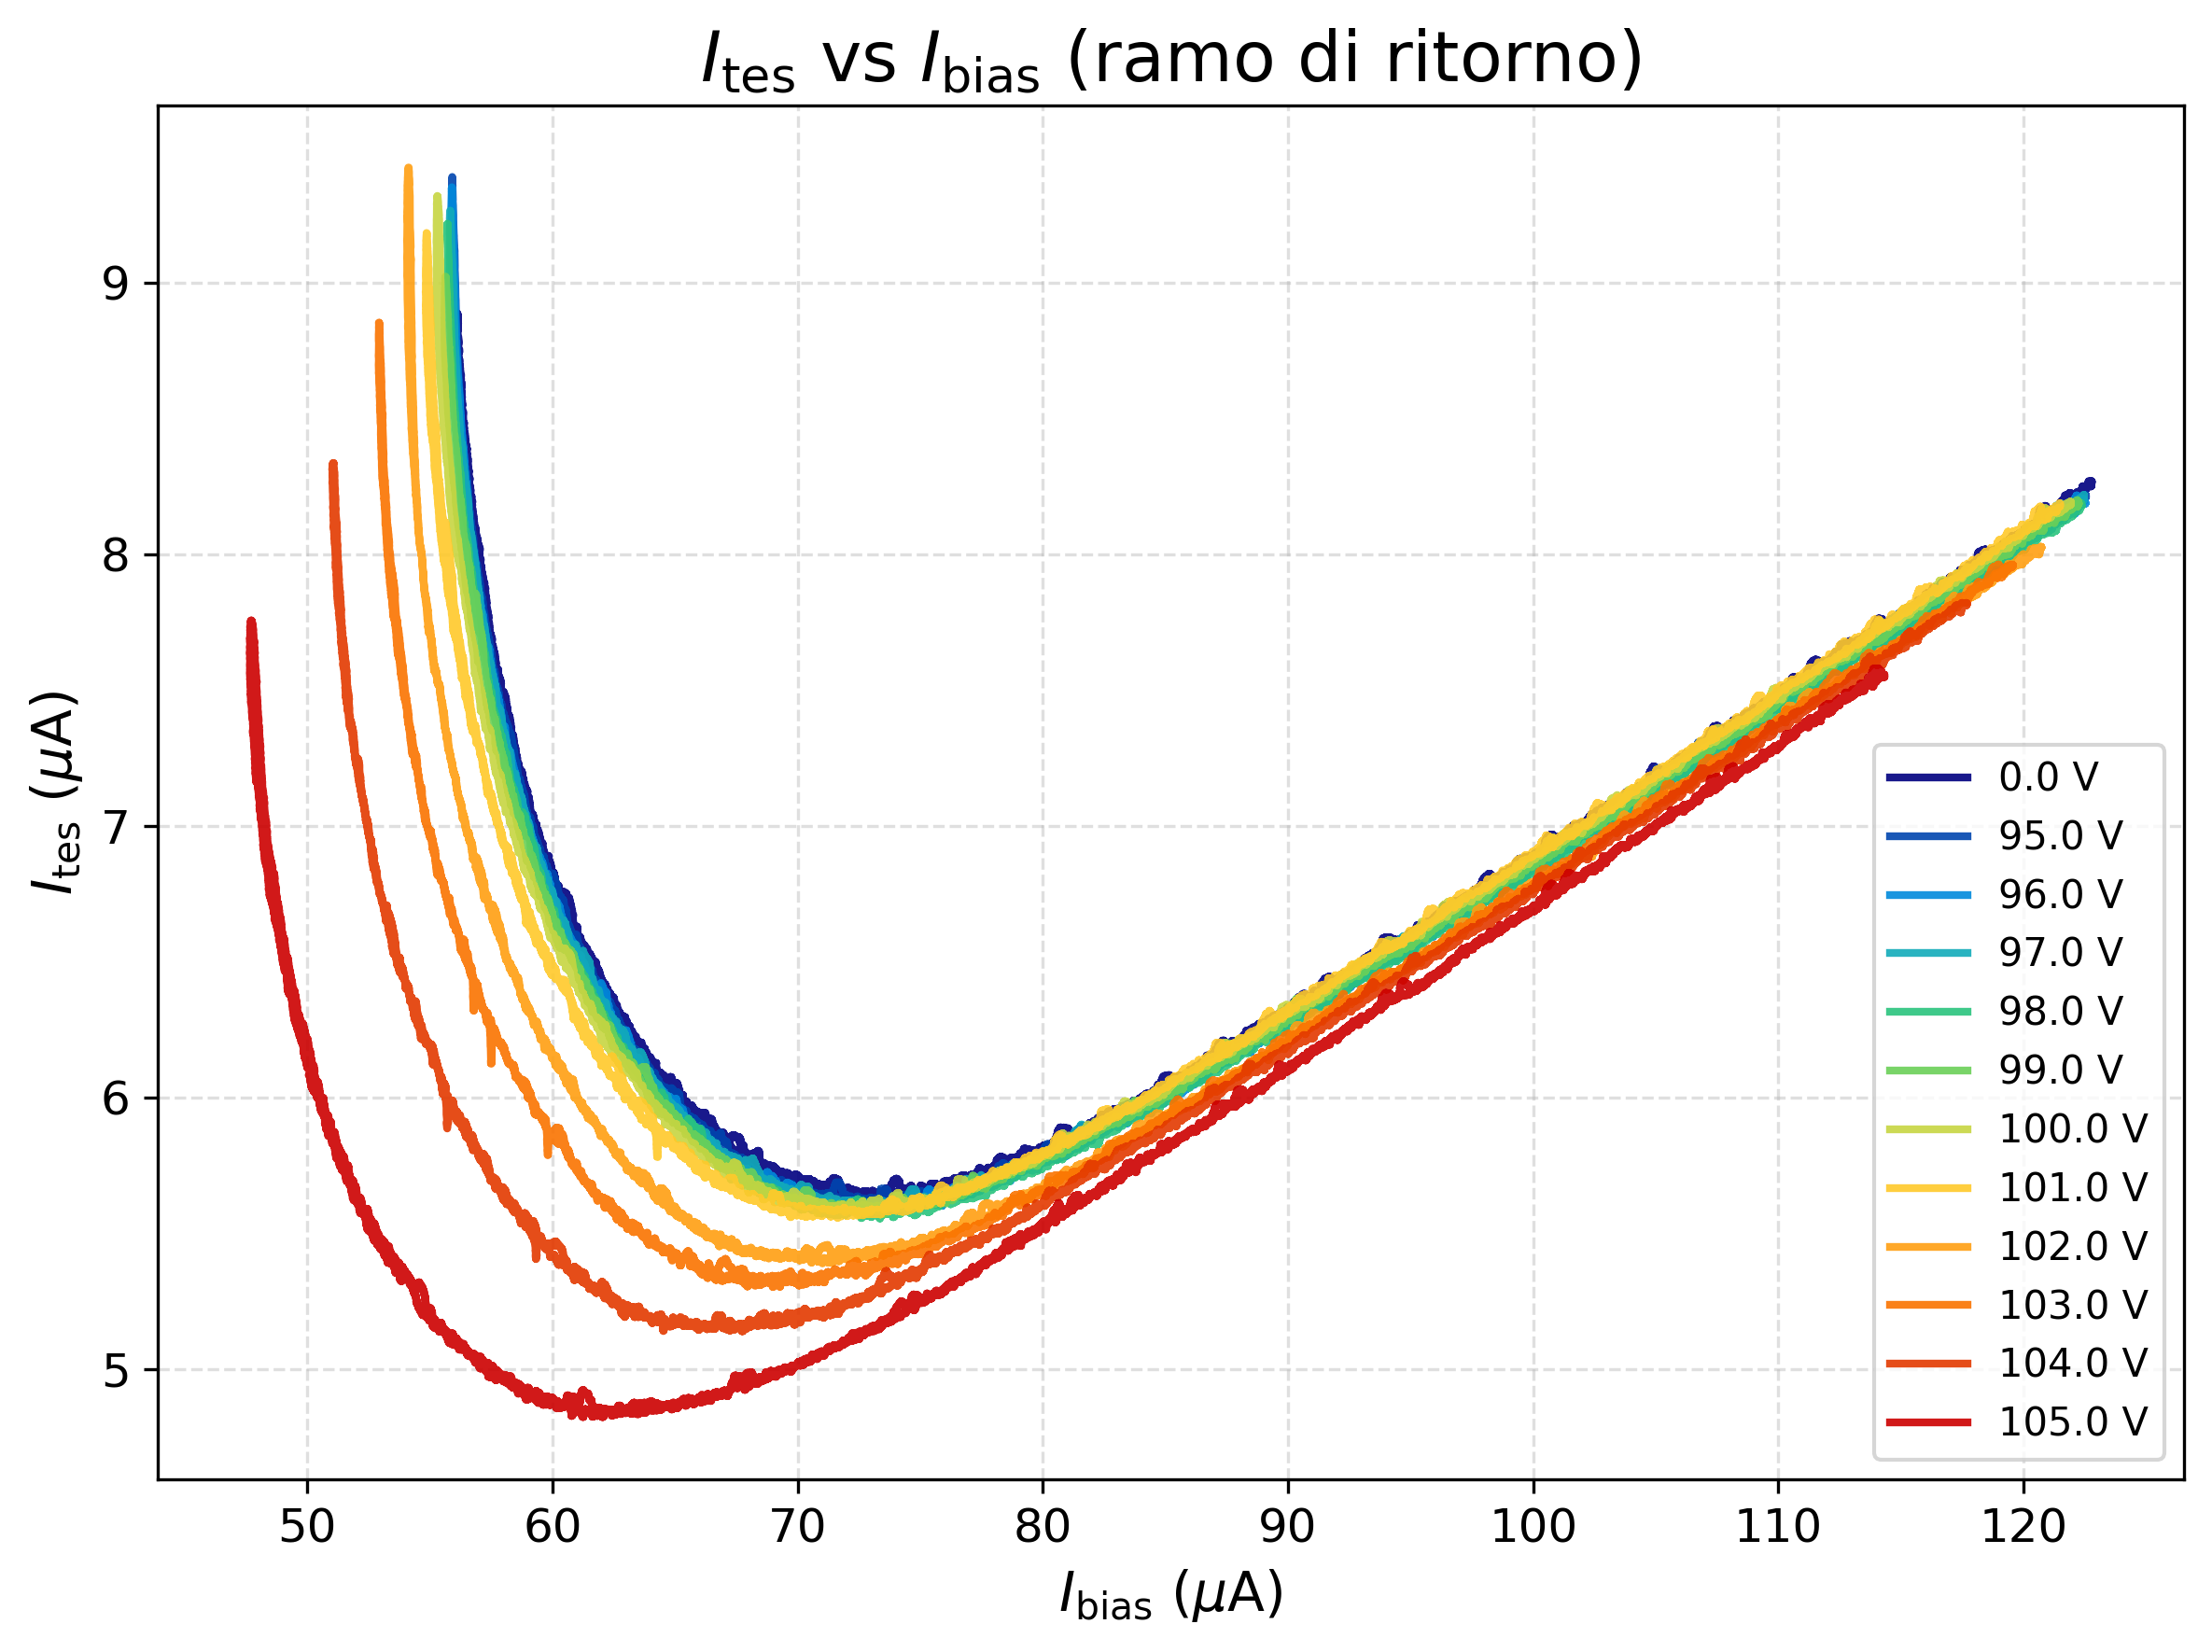

In [ ]:
#grafico di check sul ramo di ritorno della caratteristica

# Colormap custom
colors_custom = [
    (0.0, 0.0 , 0.5),   # blu scuro
    (0.0, 0.6 , 0.9),   # azzurro-blu
    (0.2, 0.8 , 0.4),   # verde tenue
    (1.0, 0.85, 0.2),   # giallo uovo
    (1.0, 0.5 , 0.0),   # arancio
    (0.8, 0.0 , 0.0)]   # rosso
cmap_custom = LinearSegmentedColormap.from_list("balanced_rainbow", colors_custom)
colors = cmap_custom(np.linspace(0, 1, len(voltages)))

plt.figure(figsize=(8, 6), dpi=300)

#zip accoppia gli elementi corrispondenti delle quattro liste
for I_bias, I_tes, V, c in zip(bias_all, tes_all, voltages, colors): #per ogni voltaggio
    
    #crea un array booleano in cui ho 1 se la differenza tra valori di I_tes consecutivi è minore di 0 e np.where
    #ridà gli indici in cui la condizione è rispettata
    decrescente_idx = np.where(np.diff(I_bias) < 0)[0] + 1 #ha gli indici di ibias decrescente
    decrescente_idx = np.insert(decrescente_idx, 0, 0)     #include primo elemento di decrescenza (sennò saltato)
    
    #estraggo solo punti della curva decrescente
    I_bias_dec = I_bias[decrescente_idx]
    I_tes_dec = I_tes[decrescente_idx]
    
    plt.plot(I_bias_dec, I_tes_dec, color=c, label=f"{V} V", linewidth=2.0, alpha=0.9)

    
plt.xlabel(r"$I_{\rm bias}$ ($\mu$A)", fontsize=14)
plt.ylabel(r"$I_{\rm tes}$ ($\mu$A)", fontsize=14)
plt.title(r"$I_{\rm tes}$ vs $I_{\rm bias}$ (ramo di ritorno)", fontsize=18)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

#le ites_ibias sono state già traslate al valore giusto dai dati di Origin, quindi i loro valori assoluti 
#sono corretti così come sono. Da qui sono state estratti i valori di R_par e R_N usando il ramo superconduttivo
#e quello di resistenza normale delle curve (con una transizione completa)

### lettura da tree delle pshapes

In [4]:
#importazione dati da tree che ho

base_folder = "/Users/massimo/Documents/phd/PTOLEMY/CD data/data/root/CD188/conteggi/"
branch_name = "pshape"
pshapes_all = {}
volts = range(95, 106)

for V in volts:
    folder_path = os.path.join(base_folder, f"{V}V")
    file_name = f"CD188_{V}V_treeraw.root"
    file_path = os.path.join(folder_path, file_name)

    if not os.path.exists(file_path):
        print(f"ATTENZIONE: file non trovato {file_path}")
        continue

    with uproot.open(file_path) as root_file:
        tree = root_file["treeraw"]  # il tree si chiama treeraw
        branch_data = tree[branch_name].array(library="np")

        # Converte ogni entry in array NumPy e prende solo i primi 2500 punti
        pshapes_list = [np.asarray(entry)[:2500] for entry in branch_data]

    # Converte in array 2D: n_pshape × 2500
    pshapes_all[V] = np.array(pshapes_list)
    print(f"Voltaggio {V}V: trovate {len(pshapes_list)} pshape")

Voltaggio 95V: trovate 924 pshape
Voltaggio 96V: trovate 1217 pshape
Voltaggio 97V: trovate 1535 pshape
Voltaggio 98V: trovate 2589 pshape
Voltaggio 99V: trovate 4500 pshape
Voltaggio 100V: trovate 6779 pshape
Voltaggio 101V: trovate 5358 pshape
Voltaggio 102V: trovate 8360 pshape
Voltaggio 103V: trovate 12300 pshape
Voltaggio 104V: trovate 9980 pshape
Voltaggio 105V: trovate 22498 pshape


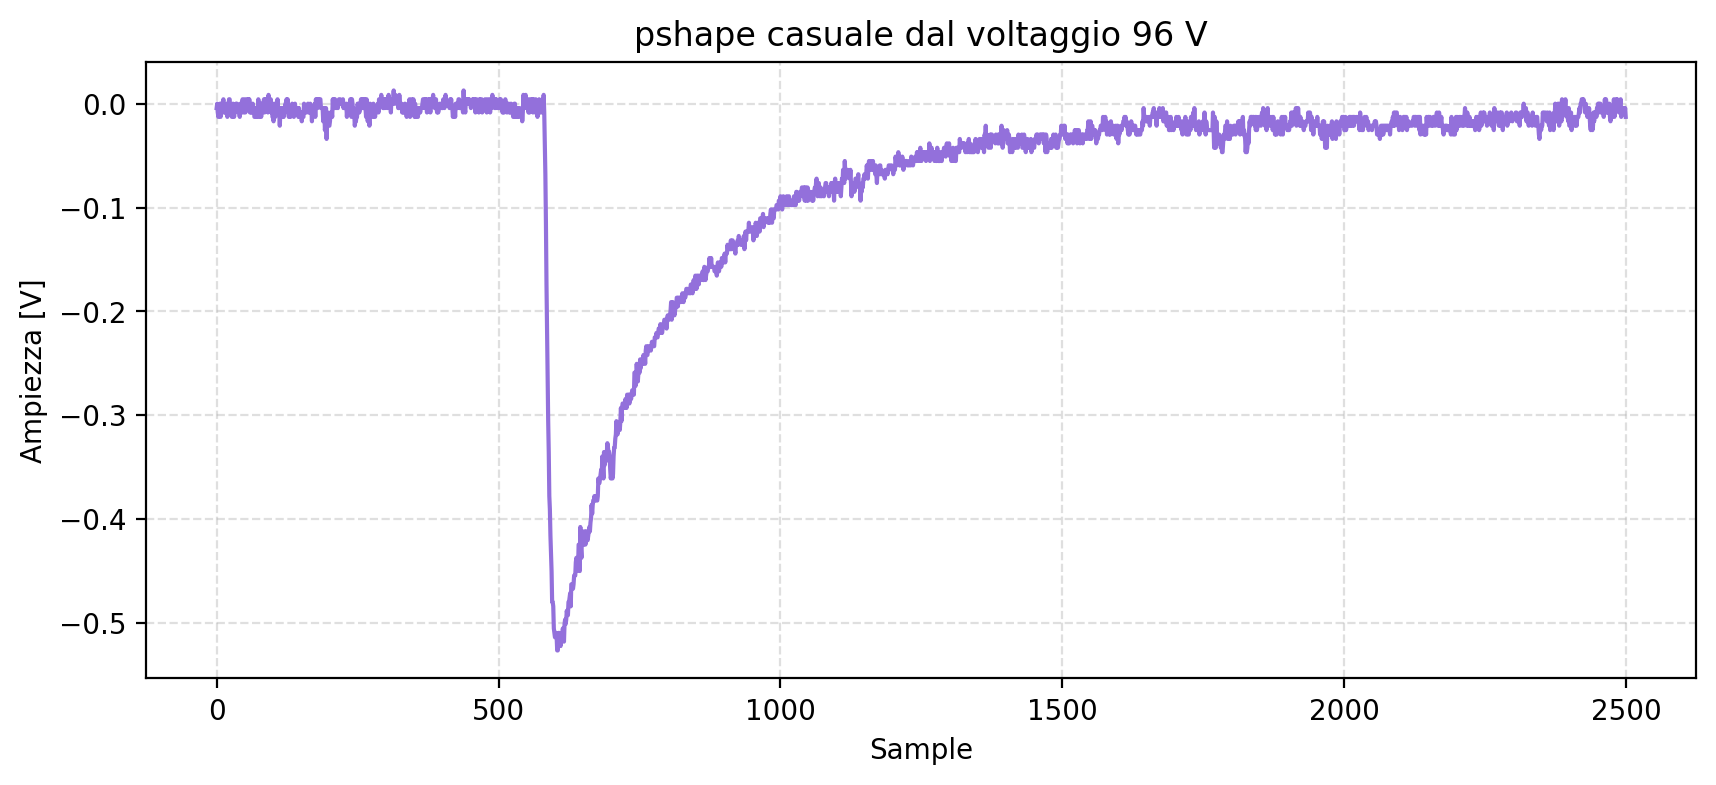

In [5]:
#check su pshape random da voltaggio random

V_random = random.choice(list(pshapes_all.keys()))
pshape_list = pshapes_all[V_random]
pshape_random = random.choice(pshape_list)

x = np.arange(len(pshape_random))
plt.figure(figsize=(10,4), dpi = 200)
plt.plot(x, pshape_random, lw=1.5, color = 'mediumpurple')
plt.xlabel("Sample")
plt.ylabel("Ampiezza [V]")
plt.title(f"pshape casuale dal voltaggio {V_random} V")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

### Elementi per calcolare la formula dell'ETF

In [7]:
def CD_Ibias(v):
    if   v == 95:  Ibias = 56.7
    elif v == 96:  Ibias = 56.7
    elif v == 97:  Ibias = 56.7
    elif v == 98:  Ibias = 56.5   
    elif v == 99:  Ibias = 56.4
    elif v == 100: Ibias = 56.2
    elif v == 101: Ibias = 55.7
    elif v == 102: Ibias = 54.9
    elif v == 103: Ibias = 53.7
    elif v == 104: Ibias = 51.8
    elif v == 105: Ibias = 48.4
    return Ibias * 1e-6  # converte µA in A

R_N     = 0.235
R_tes   = R_N * 0.35
R_shunt = 0.02
R_par   = 0.045
R_L     = R_shunt + R_par
G       = 1/269443

def GetI_0(v):
    return CD_Ibias(v) * R_shunt / (R_tes + R_L)

In [8]:
# Dizionari per salvare pshape moltiplicate per G e pshape^2
pshape_I = {}
pshape_I2 = {}

for V, pshape_array in pshapes_all.items():
    # Moltiplica tutte le pshape per il gain G
    pshape_scaled = pshape_array * G  
    pshape_I[V]   = pshape_scaled
    pshape_I2[V] = pshape_scaled ** 2  # calcolato punto per punto

#check di quante pshape_I ci sono per ogni voltaggio
for V, pshape_array in pshape_I.items():
    print(f"Voltaggio {V} V: {len(pshape_array)} pshape_I")

Voltaggio 95 V: 924 pshape_I
Voltaggio 96 V: 1217 pshape_I
Voltaggio 97 V: 1535 pshape_I
Voltaggio 98 V: 2589 pshape_I
Voltaggio 99 V: 4500 pshape_I
Voltaggio 100 V: 6779 pshape_I
Voltaggio 101 V: 5358 pshape_I
Voltaggio 102 V: 8360 pshape_I
Voltaggio 103 V: 12300 pshape_I
Voltaggio 104 V: 9980 pshape_I
Voltaggio 105 V: 22498 pshape_I


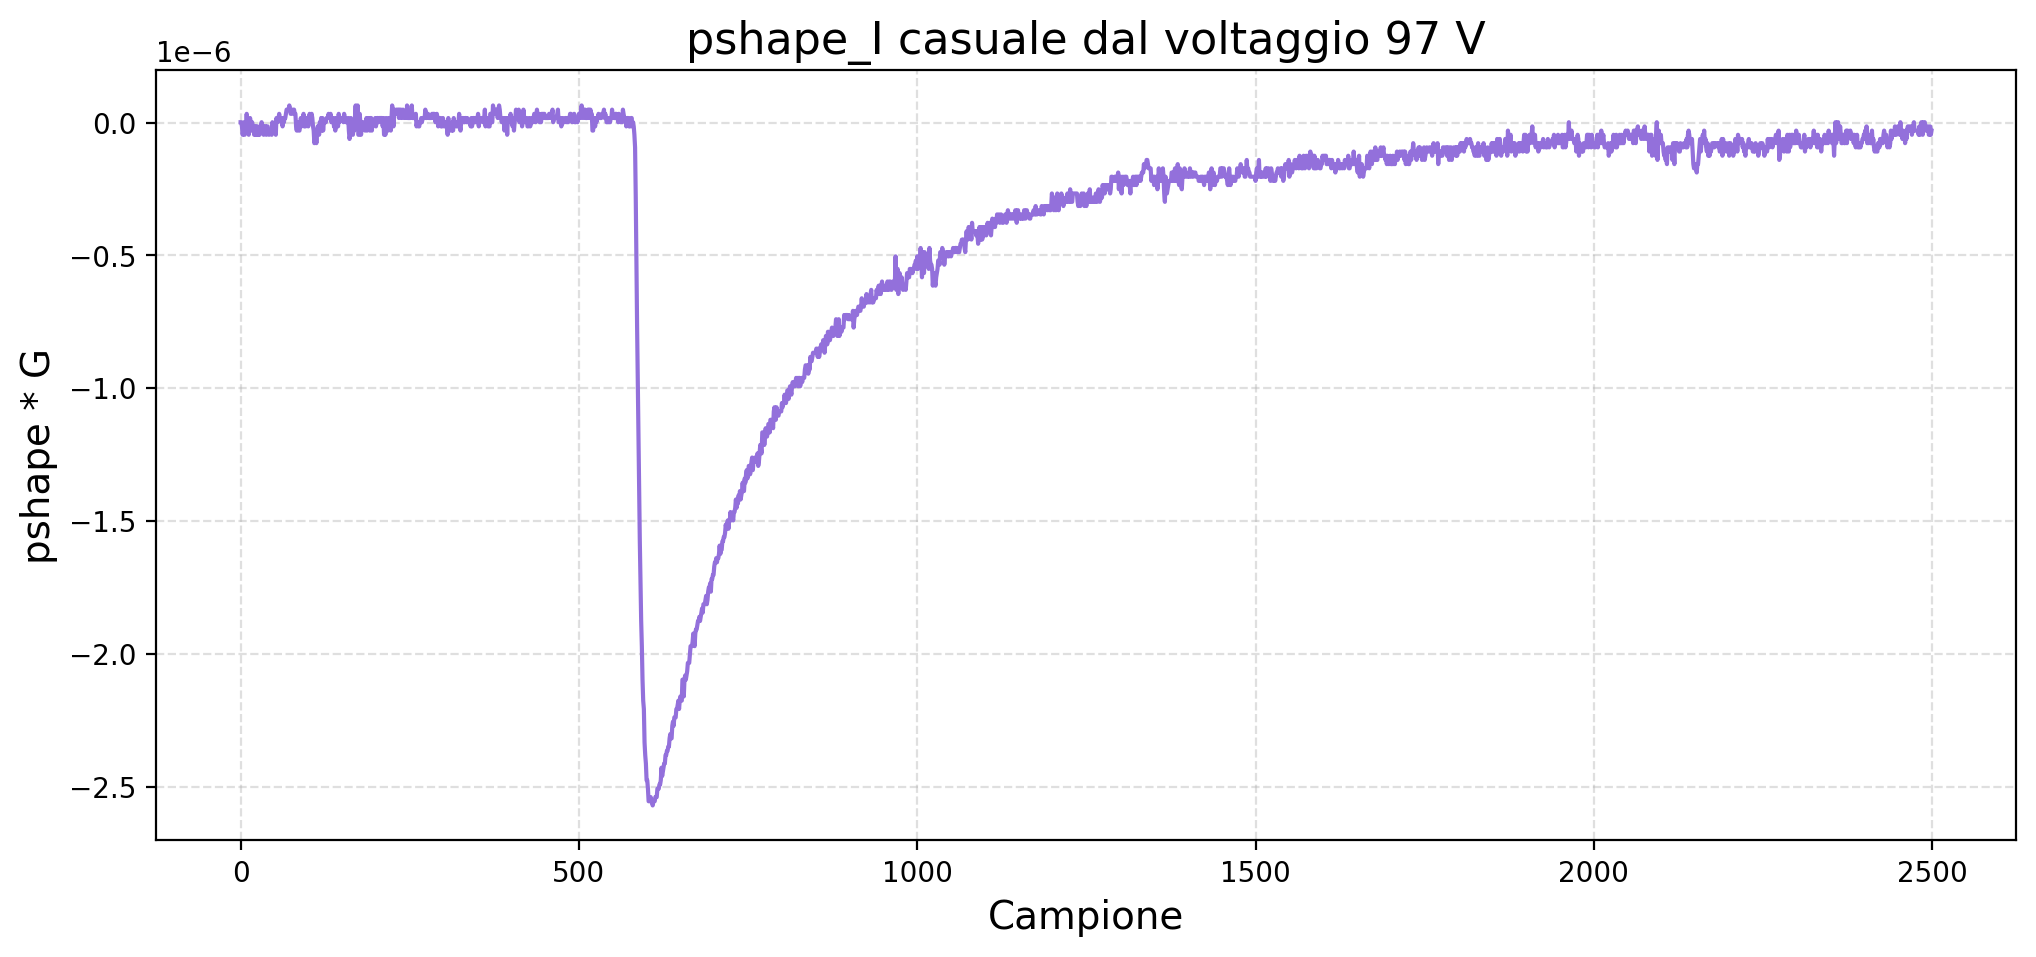

In [9]:
# controllo su una pshape di corrente a caso da voltaggio a caso
V_random = random.choice(list(pshape_I.keys()))
pshape_list = pshape_I[V_random]
pshape_random = random.choice(pshape_list)

x = np.arange(len(pshape_random))
plt.figure(figsize=(12,5), dpi=200)
plt.plot(x, pshape_random, lw=1.5, color='mediumpurple')
plt.xlabel("Campione", fontsize=14)
plt.ylabel("pshape * G", fontsize=14)
plt.title(f"pshape_I casuale dal voltaggio {V_random} V", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [10]:
#funzione di integrazione rispetto a una baseline
def integrate_baseline(pshape, dt=4e-08):   # dt è intervallo di tempo tra un punto e l'altro 
    pshape   = np.asarray(pshape)           # conversione in numpy.ndarray
    baseline = np.mean(pshape[10:200])      # calcola baseline da punto 10 a punto 200
    return np.cumsum( pshape - baseline)[-1] * dt   

# calcola la cumulativa dell'array di differenze e la mette in un array. [-1] vuol dire che mi faccio ridare
# l'ultimo elemento, quindi la somma completa

### formula dell'ETF da implementare

![ETF](ETF2.png)

In [11]:
# Funzione per calcolare R_tes dato Ites, usando il fit polinomiale e la formula
def compute_Rtes_from_Ites(I_tes, I_bias_pol, R_shunt, R_par):
    R_tes = (I_bias_pol * R_shunt / I_tes) - (R_shunt + R_par)  
    return R_tes

In [12]:
# Dizionario per salvare E_ETF per ogni voltaggio
E_ETF_all = {}  
J_to_eV = 1 / (1.602e-19)
# Ciclo su tutti i voltaggi
for V in volts:
    E_list = [] # lista per questo voltaggio
    ibias_thisvoltage  = CD_Ibias(V)
    ites_thisvoltage = GetI_0(V)
    
    # Cicla su ogni pshape del voltaggio
    for idx in range(len(pshape_I[V])): 
        pshape_i      = pshape_I[V][idx]        # pshape * G
        pshape_i2     = pshape_I2[V][idx]       # pshape^2
        
        # Calcolo dei termini
        piece1 = - R_shunt * (ibias_thisvoltage - ites_thisvoltage) * integrate_baseline(pshape_i)
        piece2 = R_par * ites_thisvoltage * integrate_baseline(pshape_i)
        piece3 = (R_par + R_shunt) * integrate_baseline(pshape_i2)
        
        # E_ETF per questa pshape
        E = piece1 + piece2 + piece3
        E_list.append( E * J_to_eV)

    # Salva nel dizionario (array 1D) di E_ETF per quel voltaggio
    E_ETF_all[V] = np.array(E_list)

### disegno istogrammi di risultato

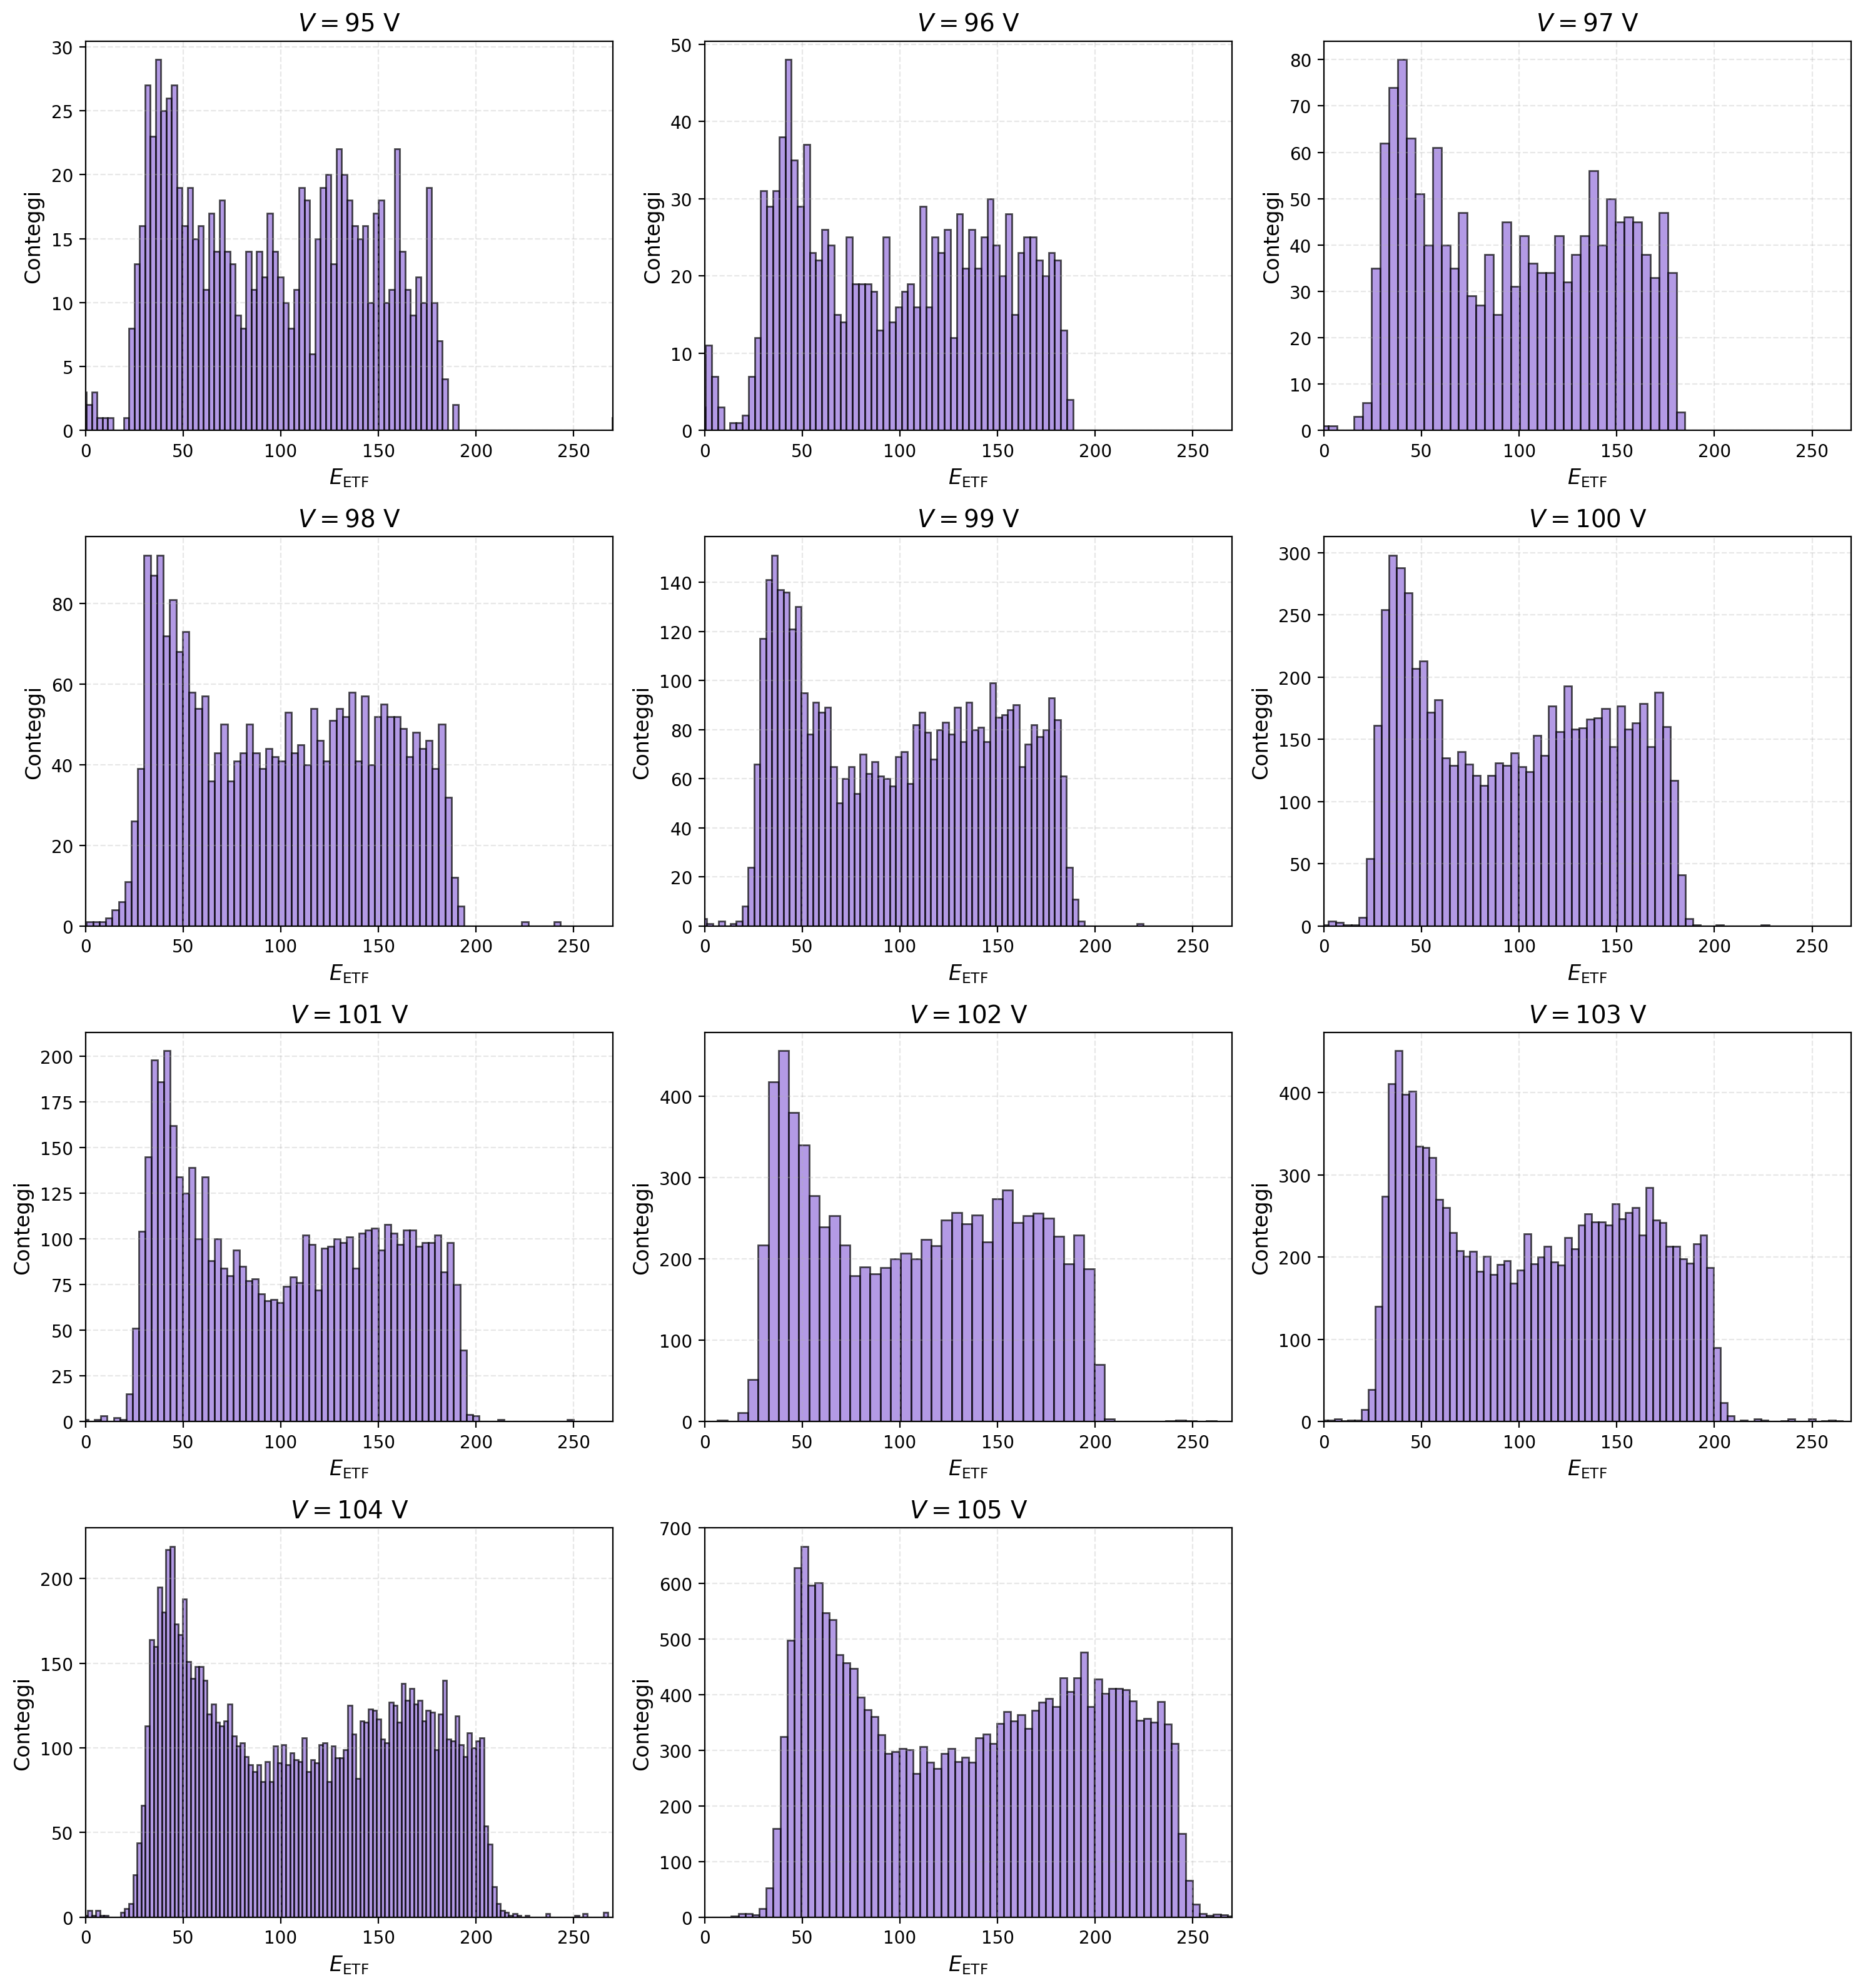

In [13]:
# Numero totale di voltaggi
n_volts = len(volts)

n_cols = 3
n_rows = int(np.ceil(n_volts / n_cols))
plt.figure(figsize=(5*n_cols, 4*n_rows), dpi=200)

# Ciclo su ogni voltaggio e relativo E_ETF
for i, V in enumerate(volts):
    plt.subplot(n_rows, n_cols, i + 1)

    # Controllo se il voltaggio è tra quelli speciali
    if V in [95, 102, 104, 105]:
        bins = 250
    else:
        bins = 100

    plt.hist(E_ETF_all[V], bins=bins, color='mediumpurple', edgecolor='black', alpha=0.7)
    plt.xlabel(r"$E_{\mathrm{ETF}}$", fontsize=12)
    plt.ylabel("Conteggi", fontsize=12)
    plt.title(fr"$V = {V}\ \mathrm{{V}}$", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.xlim(0, 270)

plt.tight_layout()
plt.show()

